In [35]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import covid_19_shared

'''
Check this:
https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000
'''

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


        

In [36]:
cv_data = covid_19_shared.loadJHUData("US", True)

cv_data

,Confirmed,Recovered,Dead
Date,,,
2020-01-22,1,0,0
2020-01-23,1,0,0
2020-01-24,2,0,0
2020-01-25,2,0,0
2020-01-26,5,0,0
...,...,...,...
2020-09-20,6804814,2590671,199509
2020-09-21,6856884,2615949,199865
2020-09-22,6896218,2646959,200786


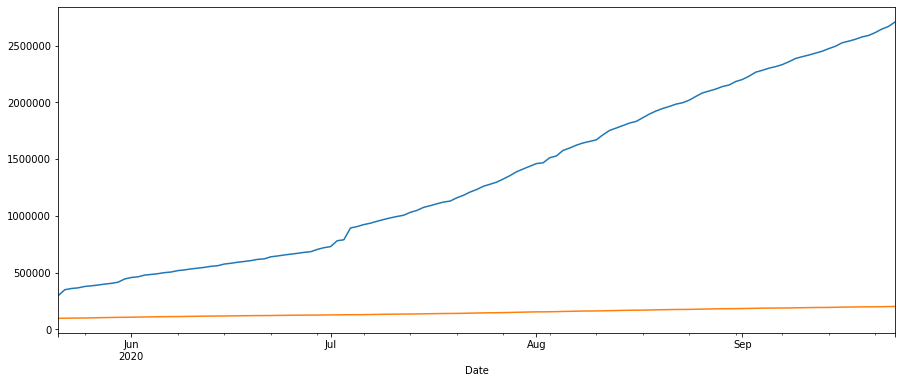

In [37]:
# Recovered Forecast
# recovered_ts = cv_data.Recovered[90:]
# deaths_ts = cv_data.Dead[90:]
skip_days = 120
recovered_ts = cv_data.Recovered[skip_days:]
deaths_ts = cv_data.Dead[skip_days:]

recovered_ts.plot()
deaths_ts.plot()

In [38]:
# Stationarity Testing
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    timeseries.plot(color='blue',label='Original')
    rolmean.plot(color='red', label='Rolling Mean')
    rolstd.plot(color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:

    dftest = adfuller(timeseries, autolag='AIC')
    print(f'Results of Dickey-Fuller Test: {dftest}')

    dfoutput = pd.Series(dftest[0:4]
                         , index=['Test Statistic'
                                  ,'p-value'
                                  ,'Num Lags Used'
                                  ,'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)
    


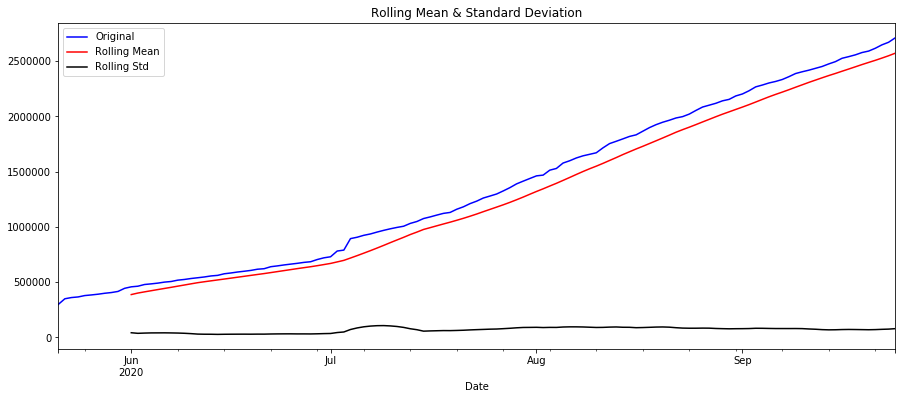

Results of Dickey-Fuller Test: (2.786366914112214, 1.0, 2, 124, {'1%': -3.484219653271961, '5%': -2.885145235641637, '10%': -2.579359138917794}, 2438.9375272212455)
Test Statistic                   2.786367
p-value                          1.000000
Num Lags Used                    2.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


In [39]:
ts = recovered_ts
test_stationarity(ts)
#test_stationarity(deaths_ts)

This is not stationary because :
- mean is increasing even though the std is small.
- Test Statistic is higher than critical value.

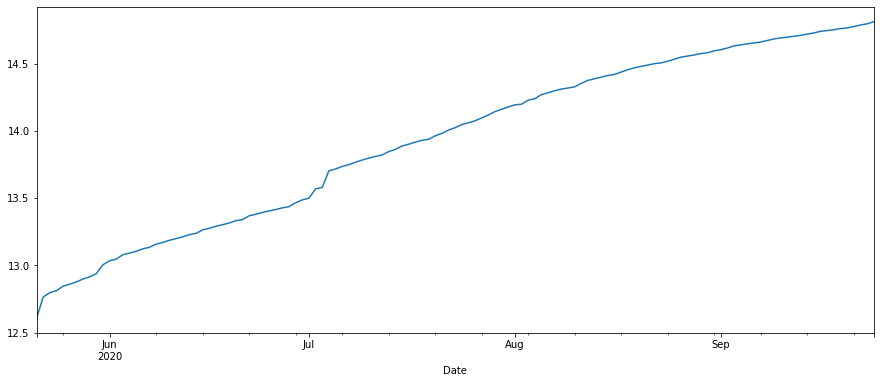

In [40]:
'''
The basic idea is to model the trend and seasonality in series,
so we can remove it and make the series stationary. 
Then we can go ahead and apply statistical forecasting 
to the stationary series. 
And finally we can convert the forecasted values 
into original by applying the trend and seasonality constrains 
back to those that we previously separated.
'''
# we must take car of the Trend (no constan mean)
# No seasonality is determined

'''
The first step is to reduce the trend using transformation, 
as we can see here that there is a strong positive trend. 
These transformation can be log, sq-rt, cube root etc . 
Basically it penalizes larger values more than the smaller. 
In this case we will use the logarithmic transformation.
'''
ts_log = np.log(ts)
ts_log.plot()

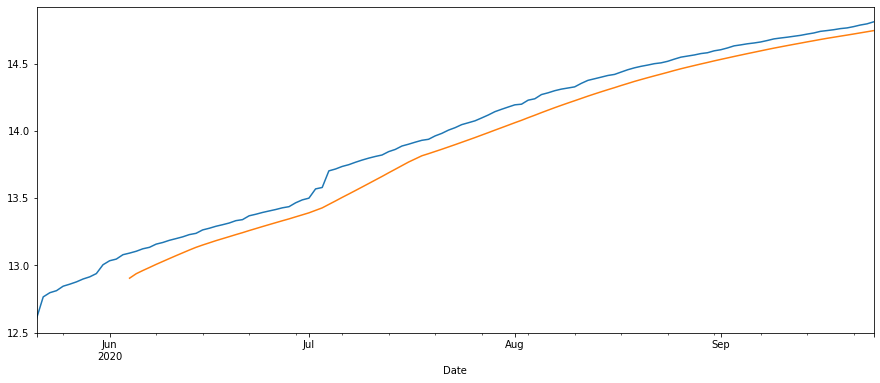

In [41]:
'''
Smoothing using rolling/moving average
'''
moving_avg = ts_log.rolling(15).mean()
ts_log.plot()
moving_avg.plot()
plt.show()



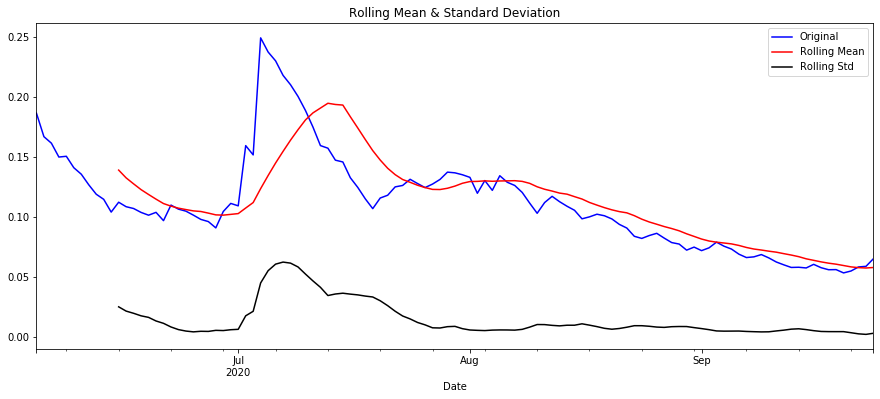

Results of Dickey-Fuller Test: (-2.2175751265622052, 0.19992864675397237, 2, 110, {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}, -597.2010563310115)
Test Statistic                  -2.217575
p-value                          0.199929
Num Lags Used                    2.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [42]:
ts_log_ma_diff = (ts_log - moving_avg).dropna()
ts_log_ma_diff.head(15)
test_stationarity(ts_log_ma_diff)

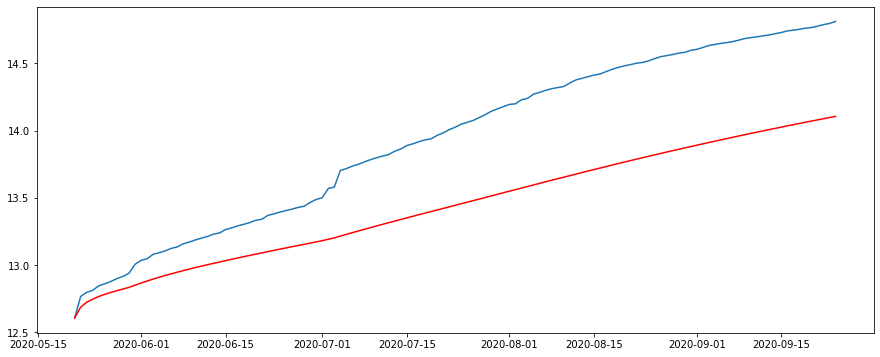

In [43]:
'''
The test statistics is smaller than the 5 % critical values. 
That tells us that we are 95% confident that this series is 
stationary.
'''

# we'll be using exponential weighted average
expwighted_avg = ts_log.ewm(halflife=90).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

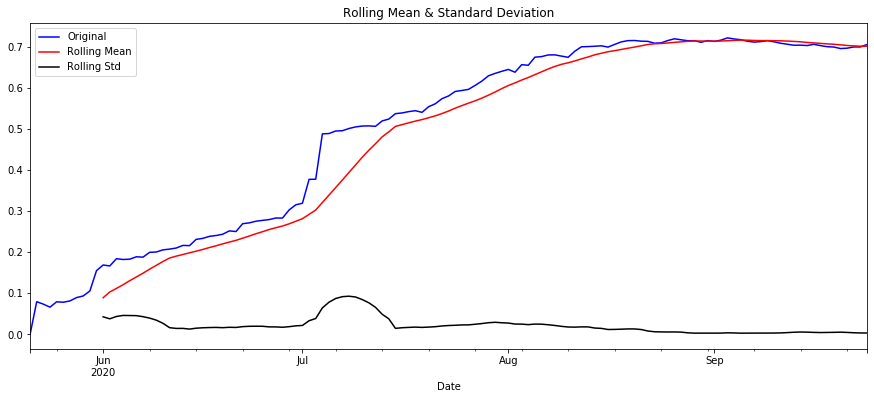

Results of Dickey-Fuller Test: (-2.446854775579956, 0.1289461544317751, 4, 122, {'1%': -3.4851223522012855, '5%': -2.88553750045158, '10%': -2.5795685622144586}, -686.4888144828235)
Test Statistic                  -2.446855
p-value                          0.128946
Num Lags Used                    4.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


In [44]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

In [45]:
%%script false --no-raise-error # do not run it 
'''
Extrapolating predicted mortality
We'll extrapolate the curve to the point where all confirmed cases
will be completed (assuming no new cases)
'''
dead = cv_data.Dead
recovered = cv_data.Recovered

df = pd.DataFrame({"Dead":dead
                   , "Recovered" : recovered
                  }
                  , index=cv_data.index
     )
df.index = range(0, len(df.index))
df.index.name = None

real_data_num = len(cv_data.index)
extrapol_num = 500 - real_data_num

df2 = pd.DataFrame({"Dead" : [np.NaN] * extrapol_num
                   , "Recovered" : [np.NaN] * extrapol_num
                   }
                   , index=range(real_data_num, 500)
                  )
df = df.append(df2)
df

df.plot(kind='line'
        , figsize=(14, 6)
        , legend=True
        , label="Completed Cases"
        , grid = True
        , color = ['red', 'green']
        , title = "Death/Recovery Update"
        )
plt.show()

# extrapolate with curve fitting
from scipy.optimize import curve_fit

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5, 0.5, 0.5)

# Function to curve fit to the data (3r order polynomial)
def func(x, a, b, c, d):
    return a * (x ** 3) + b * (x ** 2) + c * x + d

fit_df = df.dropna()

# Place to store function parameters for each column
col_params = {}

# Curve fit each column
for col in fit_df.columns:
    # Get x & y
    x = fit_df.index.astype(float).values
    y = fit_df[col].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

# Extrapolate each column
for col in df.columns:
    # Get the index values for NaNs in the column
    x = df[pd.isnull(df[col])].index.astype(float).values
    # Extrapolate those points with the fitted function
    df[col][x] = func(x, *col_params[col])

df1 = df[0:real_data_num]
df2 = df[real_data_num:]
df1.plot(kind='line'
        , figsize=(14, 6)
        , legend=True
#         , label="Completed Cases"
        , grid = True
#         , color = ['red', 'green']
        , title = "Death/Recovery Update"
        )
df2.plot(kind='line'
#         , figsize=(14, 6)
        )
plt.show()

